In [ ]:
!pip install openmeteo-requests requests-cache retry-requests

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 3.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import random
from datetime import datetime, timedelta
import openmeteo_requests
import requests_cache
from retry_requests import retry

class WeatherFetcher:
    def __init__(self, latitude, longitude, retries=5, backoff_factor=0.2):
        self.latitude = latitude
        self.longitude = longitude
        self.api_url = "https://archive-api.open-meteo.com/v1/archive"
        cache_session = requests_cache.CachedSession('.cache', expire_after=-1)
        retry_session = retry(cache_session, retries=retries, backoff_factor=backoff_factor)
        self.client = openmeteo_requests.Client(session=retry_session)

    def fetch_weather_data(self, date):
        # Fetch weather data for a specific date
        params = {
            "latitude": self.latitude,
            "longitude": self.longitude,
            "start_date": date.strftime('%Y-%m-%d'),
            "end_date": date.strftime('%Y-%m-%d'),
            "daily": ["temperature_2m_mean", "rain_sum"]
        }

        try:
            responses = self.client.weather_api(self.api_url, params=params)
            response = responses[0]
            daily = response.Daily()
            daily_temperature = daily.Variables(0).ValuesAsNumpy()[0]
            daily_rain_sum = daily.Variables(1).ValuesAsNumpy()[0]
            return daily_temperature, daily_rain_sum
        except Exception as e:
            print(f"Error fetching weather data for {date}: {str(e)}")
            return None, None


class TravelCostCalculator:
    def __init__(self, radiologist_ids):
        # Initialize travel costs for each radiologist
        self.primary_costs = {rid: round(random.uniform(5, 15), 2) for rid in radiologist_ids}

    def calculate_travel_cost(self, rid, high_cost=False):
        # Calculate travel cost, with a higher cost if conditions are met
        if high_cost:
            return round(random.uniform(15, 25), 2)
        if random.random() < 0.6:
            return self.primary_costs[rid]
        else:
            return round(random.uniform(5, 15), 2)


class PreferencesDataUpdater:
    def __init__(self, preferences_df):
        self.preferences_df = preferences_df.copy()

    def update_preferences_based_on_internet_issues(self):
        # Update work location to 'office' if there are internet issues
        self.preferences_df.loc[self.preferences_df['Internet Issues at Home'] == 'Yes', 'Morning Shift Work Location'] = 'office'
        self.preferences_df.loc[self.preferences_df['Internet Issues at Home'] == 'Yes', 'Afternoon Shift Work Location'] = 'office'
        return self.preferences_df

    def update_preferences_based_on_weather_and_travel_cost(self):
        # Update work location to 'home' if rainfall > 16mm and travel cost > £15 for 10% of affected radiologists
        condition = (self.preferences_df['Rainfall (mm)'] > 16) & (self.preferences_df['Travel Cost (£)'] > 15)
        affected_radiologists = self.preferences_df[condition]['Radiologist ID'].unique()

        for rid in affected_radiologists:
            if random.random() <= 0.1:
                self.preferences_df.loc[(self.preferences_df['Radiologist ID'] == rid) & condition, 'Morning Shift Work Location'] = 'home'
                self.preferences_df.loc[(self.preferences_df['Radiologist ID'] == rid) & condition, 'Afternoon Shift Work Location'] = 'home'
        return self.preferences_df

    def update_specific_scenarios(self):
        # Update work location for R1 when rain is 14 or above
        self.preferences_df.loc[(self.preferences_df['Radiologist ID'] == 'R1') & (self.preferences_df['Rainfall (mm)'] >= 14) & (self.preferences_df['Supervised Session'] != 'Yes'), 'Morning Shift Work Location'] = 'office'
        self.preferences_df.loc[(self.preferences_df['Radiologist ID'] == 'R1') & (self.preferences_df['Rainfall (mm)'] >= 14) & (self.preferences_df['Supervised Session'] != 'Yes'), 'Afternoon Shift Work Location'] = 'office'

        # Update work location for R8 to home every Thursday and Friday
        self.preferences_df.loc[(self.preferences_df['Radiologist ID'] == 'R8') & (self.preferences_df['Date'].dt.weekday >= 3) & (self.preferences_df['Trainee Assigned'] != 'Yes') & (self.preferences_df['Supervised Session'] != 'Yes'), 'Morning Shift Work Location'] = 'home'
        self.preferences_df.loc[(self.preferences_df['Radiologist ID'] == 'R8') & (self.preferences_df['Date'].dt.weekday >= 3)& (self.preferences_df['Trainee Assigned'] != 'Yes') & (self.preferences_df['Supervised Session'] != 'Yes'), 'Afternoon Shift Work Location'] = 'home'

        # Update work location for R10 to office every morning shift and home every afternoon shift
        self.preferences_df.loc[(self.preferences_df['Radiologist ID'] == 'R10') & (self.preferences_df['Trainee Assigned'] != 'Yes') & (self.preferences_df['Supervised Session'] != 'Yes'), 'Morning Shift Work Location'] = 'office'
        self.preferences_df.loc[(self.preferences_df['Radiologist ID'] == 'R10') & (self.preferences_df['Trainee Assigned'] != 'Yes')& (self.preferences_df['Supervised Session'] != 'Yes'), 'Afternoon Shift Work Location'] = 'home'

        # Update work location for R2 when travel cost exceeds £20
        self.preferences_df.loc[(self.preferences_df['Radiologist ID'] == 'R2') & (self.preferences_df['Travel Cost (£)'] > 20) & (self.preferences_df['Supervised Session'] != 'Yes'), 'Morning Shift Work Location'] = 'home'
        self.preferences_df.loc[(self.preferences_df['Radiologist ID'] == 'R2') & (self.preferences_df['Travel Cost (£)'] > 20)& (self.preferences_df['Supervised Session'] != 'Yes'), 'Afternoon Shift Work Location'] = 'home'

        # Update work location for R3 when temperature is below 10°C
        self.preferences_df.loc[(self.preferences_df['Radiologist ID'] == 'R3') & (self.preferences_df['Avg Temp (°C)'] < 10) & (self.preferences_df['Supervised Session'] != 'Yes'), 'Morning Shift Work Location'] = 'office'
        self.preferences_df.loc[(self.preferences_df['Radiologist ID'] == 'R3') & (self.preferences_df['Avg Temp (°C)'] < 10)& (self.preferences_df['Supervised Session'] != 'Yes'), 'Afternoon Shift Work Location'] = 'office'

        # Update work location for R7 when rainfall is between 10mm and 15mm
        self.preferences_df.loc[(self.preferences_df['Radiologist ID'] == 'R7') & (self.preferences_df['Rainfall (mm)'].between(10, 15)) & (self.preferences_df['Supervised Session'] != 'Yes'), 'Morning Shift Work Location'] = 'office'
        self.preferences_df.loc[(self.preferences_df['Radiologist ID'] == 'R7') & (self.preferences_df['Rainfall (mm)'].between(10, 15))& (self.preferences_df['Supervised Session'] != 'Yes'), 'Afternoon Shift Work Location'] = 'office'

        # Update work location for R11 when travel cost exceeds £18
        self.preferences_df.loc[(self.preferences_df['Radiologist ID'] == 'R11') & (self.preferences_df['Travel Cost (£)'] > 18) & (self.preferences_df['Supervised Session'] != 'Yes'), 'Morning Shift Work Location'] = 'home'
        self.preferences_df.loc[(self.preferences_df['Radiologist ID'] == 'R11') & (self.preferences_df['Travel Cost (£)'] > 18) & (self.preferences_df['Supervised Session'] != 'Yes'), 'Afternoon Shift Work Location'] = 'home'

        # Update work location to 'home' if both Cold Session and Admin Work are 'Yes' and Supervised Session is 'No'
        self.preferences_df.loc[
            (self.preferences_df['Cold Session'] == 'Yes') &
            (self.preferences_df['Admin Work'] == 'Yes') &
            (self.preferences_df['Supervised Session'] == 'No'),
            ['Morning Shift Work Location', 'Afternoon Shift Work Location']
        ] = 'home'

        # Update work location to 'office' if Trainee Assigned is 'Yes'
        self.preferences_df.loc[
            (self.preferences_df['Trainee Assigned'] == 'Yes'),
            ['Morning Shift Work Location', 'Afternoon Shift Work Location']
        ] = 'office'

        return self.preferences_df

class PreferenceDataGenerator:
    def __init__(self, radiologist_ids, weather_fetcher, travel_cost_calculator):
        self.radiologist_ids = radiologist_ids
        self.weather_fetcher = weather_fetcher
        self.travel_cost_calculator = travel_cost_calculator
        self.trainee_counter = 0
        self.supervised_sessions = self.generate_supervised_sessions()
        self.admin_work_days = self.generate_admin_work_days()
        self.cold_session_days = self.generate_cold_session_days()

    def generate_supervised_sessions(self):
        supervised_sessions = {rid: set() for rid in self.radiologist_ids}
        weeks = pd.date_range(start='2024-01-01', end='2024-06-30', freq='W-MON')

        for week_start in weeks:
            week_days = pd.date_range(start=week_start, periods=5, freq='B')
            for rid in self.radiologist_ids:
                if rid in ['R1', 'R3']:
                    num_sessions = 4
                elif rid in ['R8', 'R9', 'R10']:
                    num_sessions = 3
                else:
                    num_sessions = 2

                supervised_days = random.sample(list(week_days), num_sessions)
                supervised_sessions[rid].update(supervised_days)

        return supervised_sessions

    def generate_admin_work_days(self):
        admin_work_days = {rid: set() for rid in self.radiologist_ids}
        weeks = pd.date_range(start='2023-07-01', end='2024-06-30', freq='W-MON')

        for week_start in weeks:
            week_days = pd.date_range(start=week_start, periods=5, freq='B')
            for rid in self.radiologist_ids:
                admin_day = random.choice(list(week_days))
                admin_work_days[rid].add(admin_day)

        return admin_work_days

    def generate_cold_session_days(self):
        cold_session_days = {rid: set() for rid in self.radiologist_ids}
        weeks = pd.date_range(start='2024-01-01', end='2024-06-30', freq='W-MON')

        for week_start in weeks:
            week_days = pd.date_range(start=week_start, periods=5, freq='B')
            for rid in self.radiologist_ids:
                num_cold_sessions = random.choice([1, 2])
                cold_days = random.sample(list(week_days), num_cold_sessions)
                cold_session_days[rid].update(cold_days)

        return cold_session_days

    def generate_preferences(self, start_date, end_date):
        preferences_data = []
        # Specific selection of radiologists with internet issues - R4, R6 and R9
        internet_issues_radiologists = {"R4", "R6", "R9"}
        work_locations = ['home', 'office']

        for date in pd.date_range(start=start_date, end=end_date, freq='B'):
            # Specific selection of 4 radiologists per day who will have high travel costs if it rains heavily
            high_cost_radiologists = {"R2", "R5", "R6", "R7"}
            # Cyclically select radiologists for trainee assignment
            trainees_assigned = self.get_trainees_for_day()

            for rid in self.radiologist_ids:
                temperature, rainfall = self.weather_fetcher.fetch_weather_data(date)
                high_cost = False
                if rainfall is not None and rainfall > 16:
                    if rid in high_cost_radiologists:
                        high_cost = True
                travel_cost = self.travel_cost_calculator.calculate_travel_cost(rid, high_cost)

                # Determine if a trainee is assigned
                trainee_assigned = 'Yes' if rid in trainees_assigned else 'No'
                supervised_session = 'Yes' if date in self.supervised_sessions[rid] else 'No'
                admin_work = 'Yes' if date in self.admin_work_days[rid] else 'No'
                cold_session = 'Yes' if date in self.cold_session_days[rid] else 'No'

                if supervised_session == 'Yes':
                    morning_shift_location = 'office'
                    afternoon_shift_location = 'office'
                elif cold_session == 'Yes' and admin_work == 'Yes':
                    morning_shift_location = 'home'
                    afternoon_shift_location = 'home'
                else:
                    # Randomly assign work locations for morning and afternoon shifts
                    morning_shift_location = random.choice(work_locations)
                    afternoon_shift_location = random.choice(work_locations)

                # Determine internet issues based on predefined probabilities
                if rid in internet_issues_radiologists:
                    internet_issues = 'Yes' if random.random() < 0.3 else 'No'
                else:
                    internet_issues = 'Yes' if random.random() < 0.02 else 'No'

                preferences_data.append([rid, date, temperature, rainfall, travel_cost, internet_issues, morning_shift_location, afternoon_shift_location, trainee_assigned, supervised_session, cold_session, admin_work])

        return pd.DataFrame(preferences_data, columns=['Radiologist ID', 'Date', 'Avg Temp (°C)', 'Rainfall (mm)', 'Travel Cost (£)', 'Internet Issues at Home', 'Morning Shift Work Location', 'Afternoon Shift Work Location', 'Trainee Assigned', 'Supervised Session', 'Cold Session', 'Admin Work'])

    def get_trainees_for_day(self):
        trainees = []
        for _ in range(2):
            trainees.append(self.radiologist_ids[self.trainee_counter])
            self.trainee_counter = (self.trainee_counter + 1) % len(self.radiologist_ids)
        return trainees


def main():
    radiologist_ids = [f"R{i}" for i in range(1, 12)]
    # Location taken into consideration: Leicester
    weather_fetcher = WeatherFetcher(latitude=52.6369, longitude=1.1398)
    travel_cost_calculator = TravelCostCalculator(radiologist_ids)
    data_generator = PreferenceDataGenerator(radiologist_ids, weather_fetcher, travel_cost_calculator)

    start_date = '2023-07-01'
    end_date = '2024-06-30'
    preferences_df = data_generator.generate_preferences(start_date, end_date)

    updater = PreferencesDataUpdater(preferences_df)
    updated_preferences_df = updater.update_preferences_based_on_internet_issues()
    updated_preferences_df = updater.update_preferences_based_on_weather_and_travel_cost()
    updated_preferences_df = updater.update_specific_scenarios()

    # Reorder columns to move 'Morning Shift Work Location' and 'Afternoon Shift Work Location' to the end
    columns = [col for col in updated_preferences_df.columns if col not in ['Morning Shift Work Location', 'Afternoon Shift Work Location']]
    columns += ['Morning Shift Work Location', 'Afternoon Shift Work Location']
    updated_preferences_df = updated_preferences_df[columns]

    updated_preferences_df.to_csv("simulated_data.csv", index=False)
    print("Updated preferences data saved to 'simulated_data.csv'.")

if __name__ == "__main__":
    main()


Updated preferences data saved to 'simulated_data.csv'.


Common Conditions for All Radiologists:
- Internet Issues at Home:
  If a radiologist has internet issues at home, their work location is updated to 'office' for both morning and afternoon shifts.
- Weather and Travel Cost:
  If rainfall exceeds 16mm and travel cost is greater than £15, there is a 10% chance that the affected radiologists will work from 'home' for both shifts.
- Supervised Sessions:
  If a radiologist has a supervised session, their work location is 'office' for both morning and afternoon shifts.
- Cold Session and Admin Work:
  If both 'Cold Session' and 'Admin Work' are assigned and 'Supervised Session' is not assigned, the work location is updated to 'home' for both shifts.
- Trainee Assigned:
  If a trainee is assigned, the work location is 'office' for both shifts.

Specific Profiles for Each Radiologist:
- R1:
  Prefers to work from 'office' when the rainfall is 14mm or above, and there is no supervised session.
- R2:
  Prefers to work from 'home' when travel costs exceed £20, and there is no supervised session.
- R3:
  Prefers to work from 'office' when the temperature is below 10°C, and there is no supervised session.
- R4:
  More likely to have internet issues (30% probability), affecting their work location preference to 'office'.
- R5:
  Identified to have higher travel costs on rainy days, especially when it rains heavily (part of the high-cost group).
- R6:
  More likely to have internet issues (30% probability), affecting their work location preference to 'office'.
  Identified to have higher travel costs on rainy days, especially when it rains heavily (part of the high-cost group).
- R7:
  Prefers to work from 'office' when rainfall is between 10mm and 15mm, and there is no supervised session.
  Identified to have higher travel costs on rainy days, especially when it rains heavily (part of the high-cost group).
- R8:
  Prefers to work from 'home' every Thursday and Friday, provided there is no trainee assigned and no supervised session.
- R9:
  More likely to have internet issues (30% probability), affecting their work location preference to 'office'.
- R10:
  Always prefers to work from 'office' for morning shifts and 'home' for afternoon shifts, provided there is no trainee assigned and no supervised session.
- R11:
  Prefers to work from 'home' when travel costs exceed £18, and there is no supervised session.

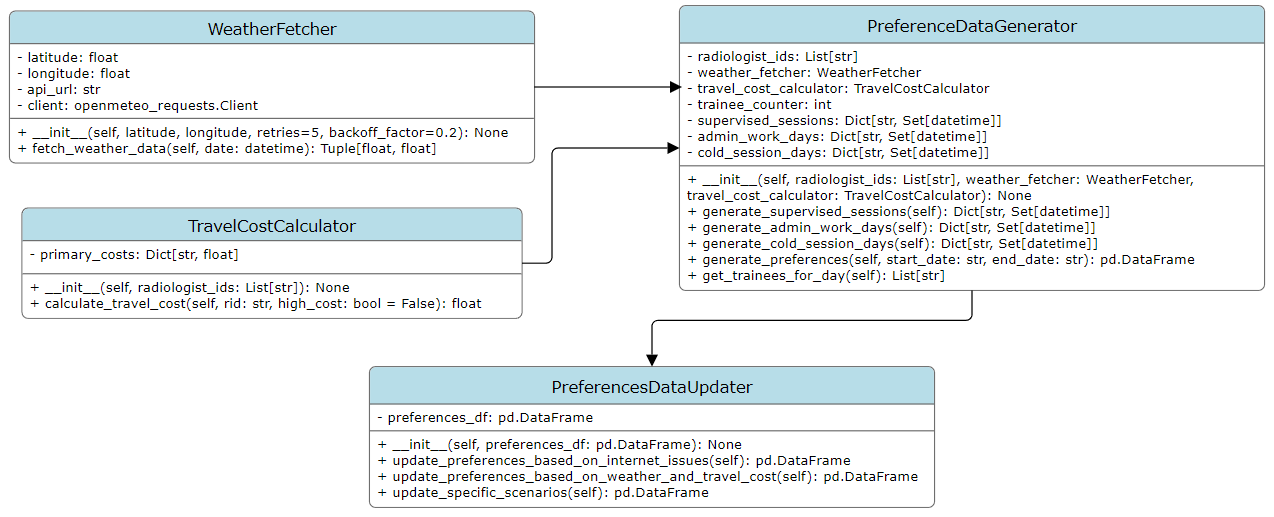